dat shape (neurons x trials): (39209, 5900)
Neuron 42 non-zero events: 336 / 5900

Neuron 42 performance:
  Accuracy:  0.596
  Precision: 0.056
  Recall:    0.397

Mean P(y=1) for true events: 0.392
Array shape: (78,)


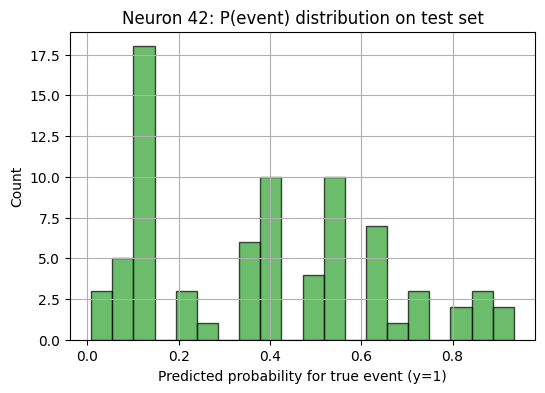

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skbio.stats.composition import clr
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import pickle
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Load data ---
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))  # (118, 1000)
X = softmax(embeddings, axis=1)

# --- Compute trial structure ---
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split images by identity (no trial leakage)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# --- Binarize responses ---
threshold = 0.0
Y_binary = (dat > threshold).astype(int)

# --- Apply CLR transform to embeddings ---
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)  # (5900, 1000)

# --- Choose neuron index ---
neuron_idx = 42  # <-- change to the neuron you want to analyze
y = Y_binary[neuron_idx]
print(f"Neuron {neuron_idx} non-zero events: {y.sum()} / {len(y)}")

# Skip neurons with too few events
if y.sum() < 10:
    raise ValueError("Too few non-zero events for reliable logistic regression.")

# --- Train/test split based on image identities ---
X_train, X_test = X_trials_clr[train_mask], X_trials_clr[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# --- Fit logistic regression ---
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    penalty='l2',
    solver='liblinear'
)
model.fit(X_train, y_train)

# --- Predict probabilities ---
y_prob = model.predict_proba(X_test)[:, 1]  # P(y=1|X)
y_pred = (y_prob > 0.5).astype(int)

# --- Evaluate metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

print(f"\nNeuron {neuron_idx} performance:")
print(f"  Accuracy:  {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall:    {rec:.3f}")

# --- Extract probabilities corresponding to non-zero (event) ground truth ---
nonzero_probs = y_prob[y_test == 1]
print(f"\nMean P(y=1) for true events: {nonzero_probs.mean():.3f}")
print(f"Array shape: {nonzero_probs.shape}")

# --- Plot histogram of event probabilities ---
plt.figure(figsize=(6, 4))
plt.hist(nonzero_probs, bins=20, color='tab:green', alpha=0.7, edgecolor='k')
plt.xlabel("Predicted probability for true event (y=1)")
plt.ylabel("Count")
plt.title(f"Neuron {neuron_idx}: P(event) distribution on test set")
plt.grid(True)
plt.show()


In [4]:
from sklearn.metrics import roc_auc_score

def classifier_advantage(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    advantage = 2 * abs(auc - 0.5)
    return advantage

adv = classifier_advantage(y_test, y_prob)
print(f"Classifier cryptographic advantage: {adv:.5f}")


Classifier cryptographic advantage: 0.00048


dat shape (neurons x trials): (39209, 5900)
Neuron 103 non-zero events: 327 / 5900

Neuron 103 performance:
  Accuracy:  0.609
  Precision: 0.060
  Recall:    0.516

Mean P(y=1) for true events: 0.503
Array shape: (64,)


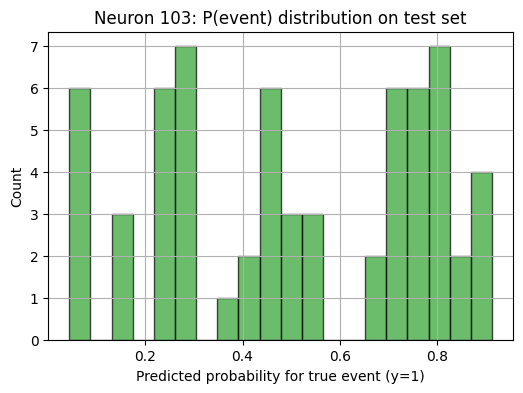

Classifier cryptographic advantage: 0.20098


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skbio.stats.composition import clr
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import pickle
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Load data ---
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))  # (118, 1000)
X = softmax(embeddings, axis=1)

# --- Compute trial structure ---
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split images by identity (no trial leakage)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# --- Binarize responses ---
threshold = 0.0
Y_binary = (dat > threshold).astype(int)

# --- Apply CLR transform to embeddings ---
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)  # (5900, 1000)

# --- Choose neuron index ---
neuron_idx = 103  # <-- change to the neuron you want to analyze
y = Y_binary[neuron_idx]
print(f"Neuron {neuron_idx} non-zero events: {y.sum()} / {len(y)}")

# Skip neurons with too few events
if y.sum() < 10:
    raise ValueError("Too few non-zero events for reliable logistic regression.")

# --- Train/test split based on image identities ---
X_train, X_test = X_trials_clr[train_mask], X_trials_clr[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# --- Fit logistic regression ---
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    penalty='l2',
    solver='liblinear'
)
model.fit(X_train, y_train)

# --- Predict probabilities ---
y_prob = model.predict_proba(X_test)[:, 1]  # P(y=1|X)
y_pred = (y_prob > 0.5).astype(int)

# --- Evaluate metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

print(f"\nNeuron {neuron_idx} performance:")
print(f"  Accuracy:  {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall:    {rec:.3f}")

# --- Extract probabilities corresponding to non-zero (event) ground truth ---
nonzero_probs = y_prob[y_test == 1]
print(f"\nMean P(y=1) for true events: {nonzero_probs.mean():.3f}")
print(f"Array shape: {nonzero_probs.shape}")

# --- Plot histogram of event probabilities ---
plt.figure(figsize=(6, 4))
plt.hist(nonzero_probs, bins=20, color='tab:green', alpha=0.7, edgecolor='k')
plt.xlabel("Predicted probability for true event (y=1)")
plt.ylabel("Count")
plt.title(f"Neuron {neuron_idx}: P(event) distribution on test set")
plt.grid(True)
plt.show()


from sklearn.metrics import roc_auc_score

def classifier_advantage(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    advantage = 2 * (auc - 0.5)
    return advantage

adv = classifier_advantage(y_test, y_prob)
print(f"Classifier cryptographic advantage: {adv:.5f}")